In [21]:
import numpy as np
from matplotlib import pyplot as plt
import argparse
import time
import cv2
import os
import imutils

In [22]:
args = {
	"mask_rcnn": "mask-rcnn-coco",
	"image1": "Image1.jpg",
    "image2": "Image2.jpg",
    "image3": "Image3.jpg",
	"confidence": 0.7,
	"threshold": 0.03,
	"iter": 100
}

In [23]:
# load the COCO class labels our Mask R-CNN was trained on
labelsPath = os.path.sep.join([args["mask_rcnn"],"object_detection_classes_coco.txt"])
LABELS = open(labelsPath).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")

In [24]:
# derive the paths to the Mask R-CNN weights and model configuration
weightsPath = os.path.sep.join([args["mask_rcnn"],"frozen_inference_graph.pb"])
configPath = os.path.sep.join([args["mask_rcnn"],"mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"])

# load our Mask R-CNN trained on the COCO dataset (90 classes)
# from disk
print("Loading Mask R-CNN from disk...")
net = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)


Loading Mask R-CNN from disk...


In [25]:
def plt_imshow(title, image):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

def plt_imshow_imsave(title,image):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()
	s = title+".jpg"
	plt.savefig(s)

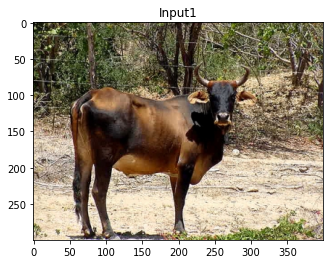

In [26]:
# load our input image from disk and display it to our screen
image1 = cv2.imread(args["image1"])
plt_imshow("Input1", image1)
image1 = imutils.resize(image1, width=600)

# construct a blob from the input image and then perform a
# forward pass of the Mask R-CNN, giving us (1) the bounding box
# coordinates of the objects in the image along with (2) the
# pixel-wise segmentation for each specific object
blob1 = cv2.dnn.blobFromImage(image1, swapRB=True, crop=False)
net.setInput(blob1)
(boxes1, masks1) = net.forward(["detection_out_final","detection_masks"])
#print(boxes1)

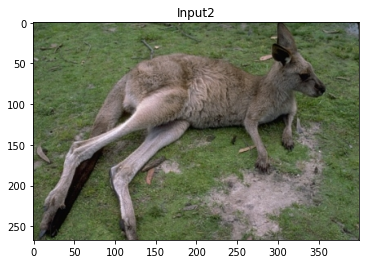

In [27]:
# load our input image from disk and display it to our screen
image2 = cv2.imread(args["image2"])
plt_imshow("Input2", image2)
image2 = imutils.resize(image2, width=600)

# construct a blob from the input image and then perform a
# forward pass of the Mask R-CNN, giving us (1) the bounding box
# coordinates of the objects in the image along with (2) the
# pixel-wise segmentation for each specific object
blob2 = cv2.dnn.blobFromImage(image2, swapRB=True, crop=False)
net.setInput(blob2)
(boxes2, masks2) = net.forward(["detection_out_final","detection_masks"])
#print(boxes2)

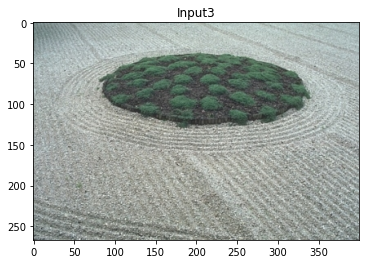

In [28]:
# load our input image from disk and display it to our screen
image3 = cv2.imread(args["image3"])
plt_imshow("Input3", image3)
image3 = imutils.resize(image3, width=600)

# construct a blob from the input image and then perform a
# forward pass of the Mask R-CNN, giving us (1) the bounding box
# coordinates of the objects in the image along with (2) the
# pixel-wise segmentation for each specific object
blob3 = cv2.dnn.blobFromImage(image3, swapRB=True, crop=False)
net.setInput(blob3)
(boxes3, masks3) = net.forward(["detection_out_final","detection_masks"])
#print(boxes2)

Applying GrabCut to 'cow' ROI...


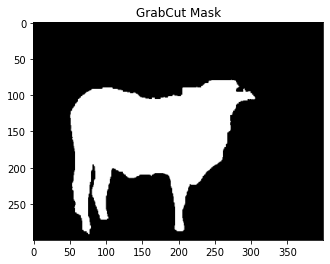

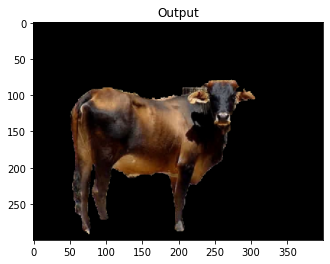

In [29]:
flag = 0

for i in range(0,boxes1.shape[2]):
    classID = int(boxes1[0,0,i,1])
    confidence = boxes1[0,0,i,2]
    #print(confidence)

    if confidence > args["confidence"]:
        flag = 1
        #print("Showing output for '{}'...".format(LABELS[classID]))

        (H,W) = image1.shape[:2]
        box = boxes1[0,0,i,3:7]*np.array([W,H,W,H])
        (startX, startY, endX, endY) = box.astype("int")
        boxW = endX - startX
        boxH = endY - startY

        mask = masks1[i, classID]
        mask = cv2.resize(mask, (boxW, boxH),interpolation=cv2.INTER_CUBIC)
        mask = (mask > args["threshold"]).astype("uint8") * 255

        rcnnMask = np.zeros(image1.shape[:2], dtype="uint8")
        rcnnMask[startY:endY, startX:endX] = mask

        rcnnOutput = cv2.bitwise_and(image1, image1, mask=rcnnMask)

        #plt_imshow("R-CNN Mask", rcnnMask)
        #plt_imshow("R-CNN Output", rcnnOutput)

        gcMask = rcnnMask.copy()
        gcMask[gcMask > 0] = cv2.GC_PR_FGD
        gcMask[gcMask == 0] = cv2.GC_BGD

        print("Applying GrabCut to '{}' ROI...".format(LABELS[classID]))

        fgModel = np.zeros((1, 65), dtype="float")
        bgModel = np.zeros((1, 65), dtype="float")

        (gcMask, bgModel, fgModel) = cv2.grabCut(image1, gcMask,None, bgModel, fgModel, iterCount=args["iter"], mode=cv2.GC_INIT_WITH_MASK)

        outputMask = np.where((gcMask == cv2.GC_BGD) | (gcMask == cv2.GC_PR_BGD), 0, 1)
        outputMask = (outputMask * 255).astype("uint8")

        output = cv2.bitwise_and(image1, image1, mask=outputMask)

        outputMask = imutils.resize(outputMask, width=400)
        output = imutils.resize(output, width=400)

        plt_imshow("GrabCut Mask", outputMask)
        cv2.imwrite("Image1_seg.png",outputMask)

        plt_imshow("Output", output)

if(flag == 0):
    print("Image Not Detected")




Applying GrabCut to 'sheep' ROI...


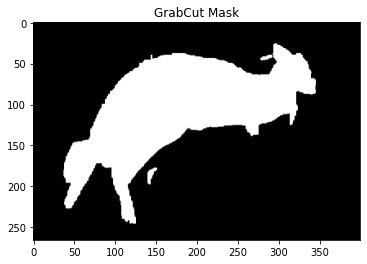

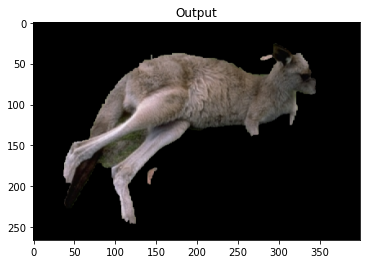

In [30]:
flag = 0
for i in range(0,boxes2.shape[2]):
    classID = int(boxes2[0,0,i,1])
    confidence = boxes2[0,0,i,2]
    #print(confidence)

    if confidence > args["confidence"]:
        flag = 1
        #print("Showing output for '{}'...".format(LABELS[classID]))

        (H,W) = image2.shape[:2]
        box = boxes2[0,0,i,3:7]*np.array([W,H,W,H])
        (startX, startY, endX, endY) = box.astype("int")
        boxW = endX - startX
        boxH = endY - startY

        mask = masks2[i, classID]
        mask = cv2.resize(mask, (boxW, boxH),interpolation=cv2.INTER_CUBIC)
        mask = (mask > args["threshold"]).astype("uint8") * 255

        rcnnMask = np.zeros(image2.shape[:2], dtype="uint8")
        rcnnMask[startY:endY, startX:endX] = mask

        rcnnOutput = cv2.bitwise_and(image2, image2, mask=rcnnMask)

        #plt_imshow("R-CNN Mask", rcnnMask)
        #plt_imshow("R-CNN Output", rcnnOutput)

        gcMask = rcnnMask.copy()
        gcMask[gcMask > 0] = cv2.GC_PR_FGD
        gcMask[gcMask == 0] = cv2.GC_BGD

        print("Applying GrabCut to '{}' ROI...".format(LABELS[classID]))

        fgModel = np.zeros((1, 65), dtype="float")
        bgModel = np.zeros((1, 65), dtype="float")

        (gcMask, bgModel, fgModel) = cv2.grabCut(image2, gcMask,None, bgModel, fgModel, iterCount=args["iter"], mode=cv2.GC_INIT_WITH_MASK)

        outputMask = np.where((gcMask == cv2.GC_BGD) | (gcMask == cv2.GC_PR_BGD), 0, 1)
        outputMask = (outputMask * 255).astype("uint8")

        output = cv2.bitwise_and(image2, image2, mask=outputMask)

        outputMask = imutils.resize(outputMask, width=400)
        output = imutils.resize(output, width=400)

        plt_imshow("GrabCut Mask", outputMask)
        cv2.imwrite("Image2_seg.png",outputMask)
        
        plt_imshow("Output", output)

if(flag == 0):
    print("Image Not Detected")

In [31]:
flag = 0
for i in range(0,boxes3.shape[2]):
    classID = int(boxes3[0,0,i,1])
    confidence = boxes3[0,0,i,2]
    #print(confidence)

    if confidence > args["confidence"]:
        flag = 1
        #print("Showing output for '{}'...".format(LABELS[classID]))

        (H,W) = image3.shape[:2]
        box = boxes3[0,0,i,3:7]*np.array([W,H,W,H])
        (startX, startY, endX, endY) = box.astype("int")
        boxW = endX - startX
        boxH = endY - startY

        mask = masks3[i, classID]
        mask = cv2.resize(mask, (boxW, boxH),interpolation=cv2.INTER_CUBIC)
        mask = (mask > args["threshold"]).astype("uint8") * 255

        rcnnMask = np.zeros(image3.shape[:2], dtype="uint8")
        rcnnMask[startY:endY, startX:endX] = mask

        rcnnOutput = cv2.bitwise_and(image3, image3, mask=rcnnMask)

        #plt_imshow("R-CNN Mask", rcnnMask)
        #plt_imshow("R-CNN Output", rcnnOutput)

        gcMask = rcnnMask.copy()
        gcMask[gcMask > 0] = cv2.GC_PR_FGD
        gcMask[gcMask == 0] = cv2.GC_BGD

        print("Applying GrabCut to '{}' ROI...".format(LABELS[classID]))

        fgModel = np.zeros((1, 65), dtype="float")
        bgModel = np.zeros((1, 65), dtype="float")

        (gcMask, bgModel, fgModel) = cv2.grabCut(image3, gcMask,None, bgModel, fgModel, iterCount=args["iter"], mode=cv2.GC_INIT_WITH_MASK)

        outputMask = np.where((gcMask == cv2.GC_BGD) | (gcMask == cv2.GC_PR_BGD), 0, 1)
        outputMask = (outputMask * 255).astype("uint8")

        output = cv2.bitwise_and(image3, image3, mask=outputMask)

        outputMask = imutils.resize(outputMask, width=400)
        output = imutils.resize(output, width=400)

        plt_imshow("GrabCut Mask", outputMask)
        cv2.imwrite("Image3_seg.png",outputMask)

        plt_imshow("Output", output)

if(flag == 0):
    print("Image Not Detected")

Image Not Detected
